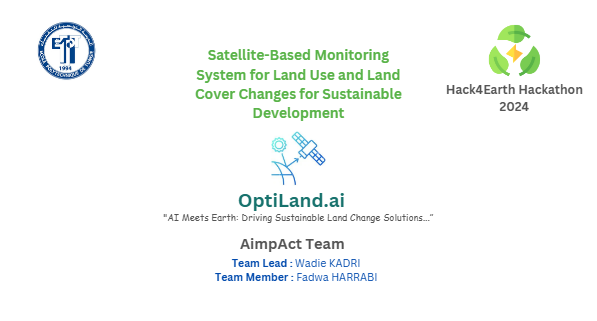

# Table of Contents


*   [Objectives](#Objectives)
*   [Context](#Context)
*   [Requirements](#Requirements)
*   [Data Description](#data-description)
*   [Results](#results)
*   [References](#references)

<a name="Objectives"></a>
# Objectives
The integration of artificial intelligence (AI) with remote sensing technologies has revolutionized our ability to map land use and land cover changes, providing crucial insights for sustainable land management and environmental conservation.

In this colab notebook, we will develop a deep learning model capable of accurately classifying satellite images into 10 land use and land cover (LULC) categories.

We will use for training, testing and validation the [EuroSAT dataset](https://zenodo.org/records/7711810#.ZAm3k-zMKEA).

<a name="Context"></a>
# Context
- A [report](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) by the World Resources Institute (WRI) states that about **23% of global human-caused GHG emissions come from land uses such as agriculture, forestry, and urban expansion**. Land use change such as deforestation and land degradation are among the primary drivers of these emissions. **Rapid urbanization leading to an increase in built-up areas as well as a massive loss of terrestrial carbon storage can also result in large carbon emissions**.

- A new special [report](https://www.wri.org/insights/7-things-know-about-ipccs-special-report-climate-change-and-land) from the Intergovernmental Panel on Climate Change (IPCC) states unequivocally that **land is critically important as well—both as a source of greenhouse gas emissions and as a climate change solution**.

Mapping the extent of land use and land cover categories over time is essential for better environmental monitoring, urban planning and nature protection. For example, monitoring changes in forest cover and identifying drivers of forest loss can be useful for forest conservation and restoration efforts. Assessing the vulnerability of certain land cover types, such as settlements and agricultural land, to certain risks can also be useful for for disaster risk reduction planning as well as long-term climate adaptation efforts.

With the increasing availability of earth observation data coupled with recent advanced in computer vision, AI & EO has paved the way for the potential to map land use and land cover at an unprecedented scale. In this tutorial, we will explore the use of Sentinel-2 satellite images and deep learning models in Pytorch to automate LULC mapping.

<br>
<center><p><p> <img src="https://ptes.org/wp-content/uploads/2018/04/iStock-664630460-e1524839082464.jpg" alt="alt" width="50%"/>




<a name="Requirements"></a>
# Requirements

This notebook requires Python >= 3.11. The following libraries are required:
 * **tqdm**: A tool to display progress bars for loops or tasks, useful for tracking long processes.
 * **pandas**: A data manipulation library, ideal for handling and analyzing structured data like tables.
 * **numpy**: A library for numerical computations, providing fast array operations and mathematical functions.
 * **matplotlib**: A plotting library for creating visualizations, including static and interactive charts.
 * **pytorch**: A deep learning framework for building neural networks and performing tensor computations, with GPU support.
 * **folium** (latest version): A library for interactive mapping.
 *   **rtree**: A spatial indexing library for efficient geospatial queries.
 *   **geopandas**: A library for working with geospatial data.
 *   **geojson**: A library for working with GeoJSON data format.
 *   **geemap**: A package that provides tools to interact with Google Earth Engine.
 *   **tornado**: A specific version of Tornado web framework required by geemap.
 * **rasterio**: A library for reading and writing geospatial raster data.
 *   **eeconvert**: A library for converting Earth Engine outputs to different formats.

## Enabling GPU in Google Colab
We will need access to the T4s GPU currently available in colab.
To enable GPU in Google Colab:
1. Navigate to Edit→Notebook Settings or Runtime→Change Runtime Type.
2. Select GPU from the Hardware Accelerator drop-down.

##Imports and Setup



In [1]:
%%capture
!pip -q install --upgrade folium
!apt install libspatialindex-dev
!pip -q install rtree
!pip -q install geopandas
!pip -q install geojson
!pip -q install geemap==0.17.3
!pip -q uninstall tornado -y
!yes | pip install tornado==5.1.0
!pip -q install rasterio
!pip -q install tqdm
!pip -q install eeconvert

In [2]:
                                                                                                                                                                    # Standard librariesimport os
import random
from tqdm.notebook import tqdm
import requests
import json

# Data manipulation and visualization
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from PIL import Image

# Geospatial processing packages
import geopandas as gpd
import geojson
import shapely
import rasterio as rio
from rasterio.plot import show
import rasterio.mask
from shapely.geometry import box

# Mapping and plotting libraries
import matplotlib.colors as cl
import ee
import eeconvert as eec
import geemap
import geemap.eefolium as emap
import folium

# Deep Learning libraries
import torch
import torchvision
import torchsummary
from torch.utils import data
from torchvision import datasets, models, transforms

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)


## Library Version Information

In [ ]:
# Data manipulation and visualization
print("seaborn version:", sns.__version__)
print("pandas version:", pd.__version__)
print("numpy version:", np.__version__)

# Geospatial processing packages
print("geopandas version:", gpd.__version__)
print("geojson version:", geojson.__version__)
print("shapely version:", shapely.__version__)
print("rasterio version:", rio.__version__)

# Mapping and plotting libraries
print("geemap version:", geemap.__version__)
print("folium version:", folium.__version__)


seaborn version: 0.13.2
pandas version: 2.2.2
numpy version: 1.26.4
geopandas version: 1.0.1
geojson version: 3.1.0
shapely version: 2.0.6
rasterio version: 1.4.1
geemap version: 0.17.3
folium version: 0.17.0


## Google Colab GPU
We need to check that the GPU  enabled in our colab notebook by running the cell below.

In [ ]:
# Check is GPU is enabled
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))

# Get specific GPU model
if str(device) == "cuda:0":
  print("GPU: {}".format(torch.cuda.get_device_name(0)))

Device: cpu


## Mount Drive

Mounting the drive will allow the Google Colab notebook to load and access files from our Google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


<a name="data-description"></a>
# Data Description

In this section, we will:
- Download the EuroSAT dataset into our Google Drive.
- Generate the train and test sets by splitting the EuroSAT dataset.
- Visualize a sample of the images and their Land Use and Land Cover labels (LULC).

## EuroSAT Dataset
The [EuroSAT dataset](https://zenodo.org/records/7711810#.ZAm3k-zMKEA) contains 27,000 labelled 64x64 pixel Sentinel-2 satellite image patches with 10 different LULC categories. Both RGB and multi-spectral (MS) images are available for download. For our project, we will focus on RGB image classification.

In [ ]:
!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip -O EuroSAT.zip
!unzip -q EuroSAT.zip -d 'EuroSAT/'
!rm EuroSAT.zip

--2024-10-13 13:58:23--  http://madm.dfki.de/files/sentinel/EuroSAT.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/zip]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  21.0MB/s    in 4.9s    

2024-10-13 13:58:28 (18.4 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]



## Generate Train and Test Sets

### Create Custom Dataset Class
In Pytorch, the "**Dataset**" **class** allows us to define a custom class to load the **input** and **target** for a dataset.  We will use it to load in our inputs in the form of **RGB satellite images along with their corresponding labels**.

In [ ]:

class EuroSAT(data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        # Apply image transformations
        if self.transform:
            x = self.transform(dataset[index][0])
        else:
            x = dataset[index][0]
        # Get class label
        y = dataset[index][1]
        return x, y

    def __len__(self):
        return len(dataset)

### Data Augmentation

Data augmentation is a  technique that **randomly applies image transformations**, e.g. crops, horizontal flips, and vertical flips, to the input images **during model training**. These perturbations **reduce the neural network's overfitting to the training dataset**, and they allow it to **generalize better to the unseen test dataset**.
<br><br>
<center> <br>
<center> <img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/0*ttoU2HOnBI8cb9Y2.png" width="400"/>
<br>
<font size=2>Image Source: <a href="https://pranjal-ostwal.medium.com/data-augmentation-for-computer-vision-b88b818b6010">https://pranjal-ostwal.medium.com/data-augmentation-for-computer-vision-b88b818b6010</a></a> </font>
<br>
</center>
</center>
<br>
<font size=2>Image Source: Ahmad, Jamil & Muhammad, Khan & Baik, Sung. (2017). Data augmentation-assisted deep learning of hand-drawn partially colored sketches for visual search. PLOS ONE. 12. e0183838. 10.1371/journal.pone.0183838. </font>
<br>


### Image Normalization
Additionally, the "**transforms.Normalize**" method normalizes each of the **three channels** to the **given means and standard deviations** defined in the "**imagenet_mean**" and "**imagenet_std**" variables.

 Given that we will use a model pre-trained on **ImageNet**, a large training dataset of images and labels, we need to ensure that our **LULC input dataset is normalized to have the same statistics (mean and standard deviation) as ImageNet**.

<br>
<center> <img src="https://cv.gluon.ai/_images/imagenet_banner.jpeg" width="400"/>
<br>
<font size=2>Image Source: <a href=" https://cv.gluon.ai/build/examples_datasets/imagenet.html">https://cv.gluon.ai/build/examples_datasets/imagenet.html</a></font>
<br>
</center>

Existing research has found that using models pretrained on massive datasets, such as ImageNet, improves accuracy when applying these neural networks to new datasets.  Pre-trained models serve as excellent generic feature extractors.  [Please read here for more information](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html).

In [ ]:
input_size = 224
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

val_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

### Load EuroSAT Dataset
We will load the EuroSAT dataset using torch's "**ImageFolder** class.

`ImageFolder` is a generic data loader where the images are arranged in this way:

```
    data
    └───AnnualCrop
    │   │   AnnualCrop_1.jpg
    │   │   AnnualCrop_2.jpg
    │   │   AnnualCrop_3.jpg
    │   │   ...
    └───Forest
    │   │   Forest_1.jpg
    │   │   Forest_2.jpg
    │   │   Forest_3.jpg
    │   │   ...
```


In [ ]:
# Load the dataset
data_dir = './EuroSAT/2750/'
dataset = datasets.ImageFolder(data_dir)
# Get LULC categories
class_names = dataset.classes
print("Class names: {}".format(class_names))
print("Total number of classes: {}".format(len(class_names)))

Class names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total number of classes: 10


### Split data into Train, Validation, and Test Sets
We split the dataset into a train set and test set. The training set will be 70% of the Eurosat dataset, randomly selected. We set aside 15% of the dataset as our validation set and the remaining 15% as our test set.

In [ ]:
# Apply different transformations to the training and test sets
train_data = EuroSAT(dataset, train_transform)
val_data = EuroSAT(dataset, val_transform)
test_data = EuroSAT(dataset, test_transform)

# Randomly split the dataset into 70% train / 15% val / 15% test
# by subsetting the transformed train and test datasets
train_size = 0.70
val_size = 0.15
indices = list(range(int(len(dataset))))
train_split = int(train_size * len(dataset))
val_split = int(val_size * len(dataset))
np.random.shuffle(indices)

train_data = data.Subset(train_data, indices=indices[:train_split])
val_data = data.Subset(val_data, indices=indices[train_split: train_split+val_split])
test_data = data.Subset(test_data, indices=indices[train_split+val_split:])
print(f"Train:{len(train_data)} Test :{len(test_data)} Validation{len(val_data)}")

Train:18900 Test :4050 Validation4050


Finally, we will use "**torch`'s** " **DataLoader** class to create a dataloader.  The dataloader manages fetching samples from the datasets.

In [ ]:
num_workers = 2
batch_size = 16

train_loader = data.DataLoader(
    train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True
)
val_loader = data.DataLoader(
    val_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)
test_loader = data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers, shuffle=False
)

## Visualize Data

In the cell below, we will visualize a batch of the dataset.  The cell visualizes the input to the neural network (the RGB image) along with the associated label.

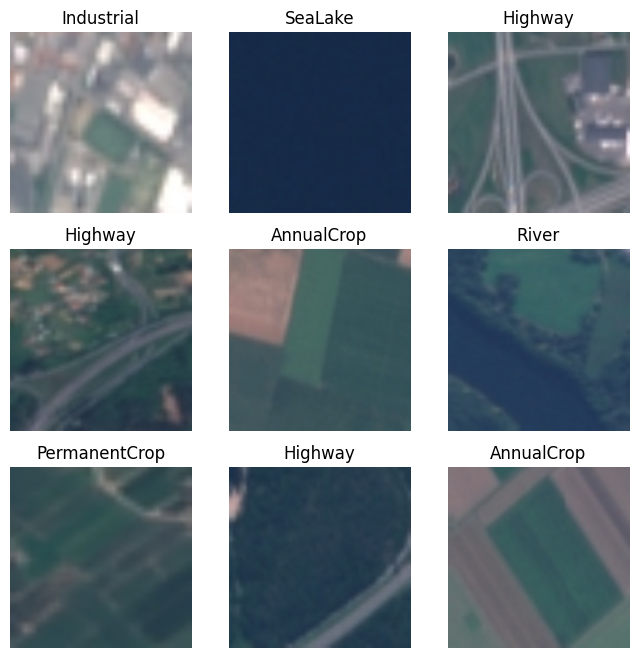

In [ ]:
n = 3
inputs, classes = next(iter(train_loader))
fig, axes = plt.subplots(n, n, figsize=(8, 8))

for i in range(n):
  for j in range(n):
    image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = class_names[classes[i * n + j]]
    axes[i, j].imshow(image)
    axes[i, j].set_title(title)
    axes[i, j].axis('off')

# Exploratory Data Analysis



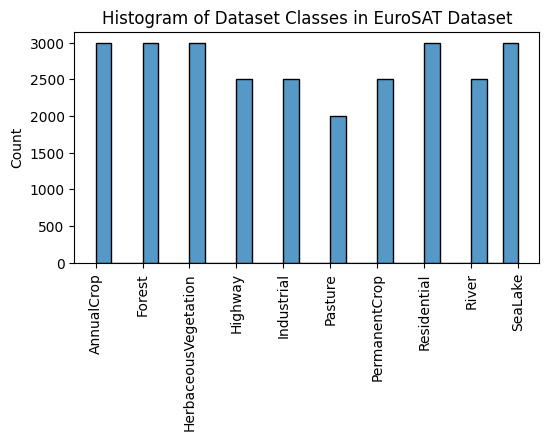

In [ ]:
plt.figure(figsize=(6, 3))
hist = sns.histplot(dataset.targets)
hist.set_xticks(range(len(dataset.classes)))
hist.set_xticklabels(dataset.classes, rotation=90)
hist.set_title('Histogram of Dataset Classes in EuroSAT Dataset')

plt.show()

# Model Development

## Instantiate Model

First, we will instatiate the model. Firstly We will use a standard neural network architecture:ResNet50. Based on [the work by Helber et al.](https://arxiv.org/pdf/1709.00029.pdf), ResNet-50 has been shown to work well for LULC classification on the EuroSAT

### ResNet-50
<b>Why Residual?</b>: Deep neural networks are difficult to train due to the problem of vanishing or exploding gradients (repeated multiplication making the gradient infinitively small). ResNet solves this by using shortcut connections that connect activation from an earlier layer to a further layer by skipping one or more layers as shown below. This allows for gradients to propagate to the deeper layers before they can be reduced to small or zero values.
<br><br>

<center> <img src="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/images/resnet50.png" width="600"/><br>
Image source: <a href="https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/">https://jananisbabu.github.io/ResNet50_From_Scratch_Tensorflow/  </a>
</center>
<br>

Note that when we load the model, we set the "**weights=models.ResNet50_Weights.DEFAULT**" to indicate that the loaded model should be already pre-trained on the Imagenet dataset. We will also modify the final layer so that the output matches the number of classes in our dataset.

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset.classes))
model = model.to(device)
torchsummary.summary(model, (3, 224, 224))

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 79.3MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

## Model Training and Evaluation

We can now proceed to model training and evaluation.

in this section we will:

1. Specify the criterion, optimizer, and hyperparameters (e.g. n_epochs, learning rate, etc.).
2. Train the model on the training set by updating its weights to minimize the loss function.
3. Evaluate the model on the test set to observe performance on new, unseen data.
4. Repeat steps 2 and 3 `n_epochs` times.

### Cross Entropy Loss
We define our loss as the cross-entropy loss, which measures the performance of a classification model whose output is a probability value between 0 and 1. Cross-entropy loss increases as the predicted probability diverges from the actual label. ([Source](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html))

For two classes, it is computed as:

$−ylog(p)-(1−y)log(1−p)$

For multiclass classification with $M$ classes, it is defined as:

$−\sum_{c=1}^{M}y_{o,c}log(p_{o,c})$

where

- $M$ - number of classes.
- $log$ - the natural log
- $y_{o,c}$ - binary indicator (0 or 1) if class label $c$ is the classification for observation $o$
- $p_{o,c}$- predicted probability observation $o$ is of class $c$

### Stochastic Gradient Descent
The goal of stochastic gradient descent (SGD) is to minimize the loss function. To do this, it computes the slope (gradient) of the loss function at the current point and moves in the opposite direction of the slope towards the steepest descent.
<center> <img src="https://miro.medium.com/max/1400/1*P7z2BKhd0R-9uyn9ThDasA.png" width="350"/><br>Image source:
<a href="https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a">https://towardsdatascience.com/batch-mini-batch-stochastic-gradient-descent-7a62ecba642a</a>
</center>
<br>

In [ ]:
# Specify number of epochs and learning rate
n_epochs = 20
lr = 1e-3
# Specify criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

Next. we will create our training function.

In [ ]:
def train(model, dataloader, criterion, optimizer):
  model.train()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Zero the parameter gradients
    # Clear off previous weights in order
    # to obtain updated weights.
    optimizer.zero_grad()

    # Forward pass
    outputs = model(inputs)

    # Compute the loss
    loss = criterion(outputs, labels)

    # Compute the gradients wrt the loss
    loss.backward()

    # Update the weights based on the
    # internally stored gradients
    optimizer.step()

    # Calculate statistics
    _, preds = torch.max(outputs, 1)

    # Calculate running loss and accuracy
    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"Train Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Next, we will define the model evaluation function.

In [ ]:
def evaluate(model, dataloader, criterion, phase="val"):
  model.eval()

  running_loss = 0.0
  running_total_correct = 0.0

  for i, (inputs, labels) in enumerate(tqdm(dataloader)):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

    running_loss += loss.item() * inputs.size(0)
    running_total_correct += torch.sum(preds == labels)

  # Calculate epoch loss and accuracy
  epoch_loss = running_loss / len(dataloader.dataset)
  epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
  print(f"{phase.title()} Loss: {epoch_loss:.2f}; Accuracy: {epoch_accuracy:.2f}")

  return epoch_loss, epoch_accuracy

Now we will define the `fit` function for training and evaluating the model on the training set and validation set, respectively.

In [ ]:
def fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer):
  # Keep track of the best loss and
  # best model weights with the lowest loss
  best_loss = np.inf
  best_model = None

  # Train and test over n_epochs
  for epoch in range(n_epochs):
    print("Epoch {}".format(epoch+1))
    train(model, train_loader, criterion, optimizer)
    val_loss, _ = evaluate(model, val_loader, criterion)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model = model

  return best_model

We will begin now model training and evaluation in the following cell.

In [ ]:
best_model = fit(model, train_loader, val_loader, n_epochs, lr, criterion, optimizer)

Epoch 1


  0%|          | 0/1182 [00:00<?, ?it/s]

## Model Performance on the Test Set
We will select best model from the previous steps, we can evaluate the model performance on the test set.

In [ ]:
test_loss, _ = evaluate(best_model, test_loader, criterion, phase="test")

  0%|          | 0/254 [00:00<?, ?it/s]

Test Loss: 0.10; Accuracy: 97.31


## Save Model

We will define a function for saving the model to our local Google drive.


In [ ]:
import os
model_dir = "./drive/My Drive/Colab Notebooks/models/"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)

model_file = os.path.join(model_dir, 'best_model.pth')
model_file

'./drive/My Drive/Colab Notebooks/models/best_model.pth'

In [ ]:
def save_model(best_model, model_file):
  torch.save(best_model.state_dict(), model_file)
  print('Model successfully saved to {}.'.format(model_file))

In [ ]:
save_model(best_model, model_file)

Model successfully saved to ./drive/My Drive/Colab Notebooks/models/best_model.pth.


## Load Model
Now we will load the saved model from the previous step.

In [ ]:
def load_model(model_file):
  # Uncomment this to download the model file
  #if not os.path.isfile(model_file):
  #  model_file = 'best_model.pth'
  #  !gdown "13AFOESwxKmexCoOeAbPSX_wr-hGOb9YY"

  model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
  model.fc = torch.nn.Linear(model.fc.in_features, 10)
  model.load_state_dict(torch.load(model_file))
  model.eval()

  print('Model file {} successfully loaded.'.format(model_file))
  return model

In [ ]:
model = load_model(model_file)

<ipython-input-31-9b71e48532eb>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_file))


Model file ./drive/My Drive/Colab Notebooks/models/best_model.pth successfully loaded.


<a name="results"></a>
# Results

We will visualize an example of the neural network making a prediction.

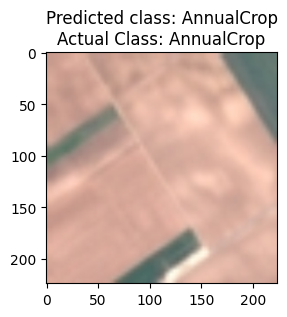

In [ ]:
# Retrieve sample image
index = 15
image, label = test_data[index]

# Predict on sample
model = model.to("cpu")
output = model(image.unsqueeze(0))
_, pred = torch.max(output, 1)

# Get corresponding class label
label = class_names[label]
pred = class_names[pred[0]]

# Visualize sample and prediction
image = image.cpu().numpy().transpose((1, 2, 0))
image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(image)
ax.set_title("Predicted class: {}\nActual Class: {}".format(pred, label));

Now, we run the model on a PIL image.

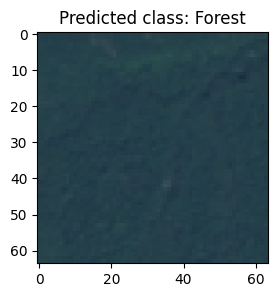

In [ ]:
from PIL import Image
image_path = './EuroSAT/2750/Forest/Forest_2.jpg'
image = Image.open(image_path)

# Transform image
input = test_transform(image)

# Predict on sample
output = model(input.unsqueeze(0))

# Get corresponding class label
_, pred = torch.max(output, 1)
pred = class_names[pred[0]]

# Visualize results
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(image)
ax.set_title("Predicted class: {}".format(pred));

# References
- Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.
- Wang, Y., Braham, N. A. A., Xiong, Z., Liu, C., Albrecht, C. M., & Zhu, X. X. (2023). SSL4EO-S12: A large-scale multimodal, multitemporal dataset for self-supervised learning in Earth observation [Software and Data Sets]. IEEE Geoscience and Remote Sensing Magazine, 11(3), 98-106.

# Land Use and Land Cover Mapping Prediction

In This second part, we will download Sentinel-2A satellite images of **Tunisia administrative districts** using Google Earth Engine, and and we will use the trained model previously to automatically generate a LULC map for our region of interest.(in this colab we will choose **Tunis** administrative district).

## Table of Contents
1. [What is Geospatial Data]()
2. [Download Country Boundaries of Tunisia](#admin-bounds)
3. [Generate Sentinel-2 Satellite Image](#sentinel-2)
4. [Generate 64x64 px GeoJSON Tiles](#tiles)
5. [Generate LULC Map](#lulc-maps)
6. [Conclusion & Next Steps]()

# What is geospatial data?


## Spatial Data Types
Spatial data observations focus on *location*. There are two main types of spatial data:
- **Vector data** - are basically points, lines, and polygons. Each vector object can consist of one or more XY coordinate locations. Vectors can be used to represent, for example, locations of places (e.g. schools, hospitals), roads, or country boundaries. Vector objects can be stored using spatial data formats such as GeoJSON (.geojson), GeoPackage (.gpkg), Shapefile (.shp).
- **Raster data** - are composed of a grid of pixels. Examples include multispectral satellite images, nighttime luminosity maps, and digital elevation maps. Each pixel represents a value or class, e.g. red, green, blue values in satellite images; night light intensity in NTL maps; height in elevation maps. Raster data are commonly stored as GeoTIFFs (.tiff).

To learn more about vectors and raster, [see this reference](https://gisgeography.com/spatial-data-types-vector-raster/).

<img src="https://slideplayer.com/slide/6229417/20/images/10/Spatial+data%3A+Vector+vs+Raster.jpg=100x100" width="350"/>

## Geospatial Data Processing Tools
We introduce the following geospatial analysis tools and Python packages:

- [**Google Earth Engine**](https://earthengine.google.com/) - a public data archive of petabytes of historical satellite imagery and geospatial datasets. In this tutorial, we will use the [Python Earth Engine API](https://developers.google.com/earth-engine/#api) to access Sentinel-2 RGB images. Note that you will need sign up for access to Google Earth Engine at https://code.earthengine.google.com/.
- [**GeoPandas**](https://geopandas.org/) - Extends the functionalities of pandas to add support for geographic data and geospatial analysis.
- [**Rasterio**](https://rasterio.readthedocs.io/en/latest/) - Raster data such as satellite images are often stored using the GeoTIFF format. Rasterio allows you to read and write these formats and perform advanced geospatial operations on these datasets.  
- [**Folium**](https://python-visualization.github.io/folium/) - Allows you to visualize geospatial data on an interactive leaflet map.

For more geospatial analysis tools, see this [comprehensive list of Python packages](https://github.com/giswqs/python-geospatial).

### Authenticate Google Earth Engine
Make sure you have signed up for access to Google Earth Engine at https://signup.earthengine.google.com/#!/. Once your request has been approved, you should be able to access Google Earth Engine at https://code.earthengine.google.com/.

In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project="optiland-ai")

<a name="admin-bounds"></a>
# Download Country Boundaries of Tunisia

Our first step is to download the administrative boundaries of our country of interest, which we will obtain via [geoBoundaries by the William and Mary GeoLab](https://www.geoboundaries.org/index.html). geoBoundaries is a free and openly accessible global database of political administrative boundaries for every country in the world. The geographic boundaries can be downloaded via API access through a simple query:

```
https://www.geoboundaries.org/gbRequest.html?ISO=[3-LETTER-ISO-CODE]&ADM=[ADM-LEVEL]
```
- **ISO** - The three-letter ISO code representing the country of interest.
  - [See this page](https://en.wikipedia.org/wiki/List_of_ISO_3166_country_codes) for the complete list of ISO codes per country.
- **ADM** - One of ADM0, ADM1, ADM2, ADM3, ADM4 or ADM5, representing each level of administrative hierarchy.

For more information, see [API documentation](https://www.geoboundaries.org/api.html).

In our project, we choose **Tunisia** as our area of interest. We set the ISO code to "TUN" and ADM to "ADM1" to select an administrative districts (Tunis). The query should return the geometries for all 24 administrative districts in Tunisia. In the following cell, we send a request for the Tunisia admin boundaries, save the result as a GeoJSON file, and read the file using GeoPandas.

In [ ]:
import requests

ISO = 'TUN' # "TUN" is the ISO code for Tunisia
ADM = 'ADM1' # Equivalent to administrative districts (Governorate example : Tunis, Monastir)

# Query geoBoundaries
url = f"https://www.geoboundaries.org/api/current/gbOpen/{ISO}/{ADM}"
r = requests.get(url)
download_path = r.json()["gjDownloadURL"]

# Save the result as a GeoJSON
filename = 'geoboundary.geojson'
geoboundary = requests.get(download_path).json()
with open(filename, 'w') as file:
   geojson.dump(geoboundary, file)

# Read data using GeoPandas
geoboundary = gpd.read_file(filename)
print("Data dimensions: {}".format(geoboundary.shape))
geoboundary.sample(10)

NameError: name 'geojson' is not defined

Now we will visualize the adminstrative boundary for **Tunis** using the GeoPandas `.plot()` function.

In [ ]:
shape_name = 'Tunis'
fig, ax = plt.subplots(1, figsize=(10,10))
geoboundary[geoboundary.shapeName == shape_name].plot('shapeName', legend=True, ax=ax);

<a name="sentinel-2"></a>
# Generate Sentinel-2 Satellite Images
Sentinel-2 is an Earth observation mission from the Copernicus Programme that provides global multispectral imagery **every 10 days** (2015 - present) at **10 m resolution** (i.e. the length of one side of a pixel is equal to 10 meters).

Images are typically composed of **3 channels or bands: red, green, and blue**. Sentinel-2, on the other hand, is able to capture **13 spectral bands**:
- 4 bands at 10 meter: blue, green, red, and near-infrared
- 6 bands at 20 meter: for vegetation characterization and for applications such as snow/ice/cloud detection or vegetation moisture stress assessment.
- 3 bands at 60 meter: mainly for cloud screening and atmospheric corrections


&nbsp; &nbsp; &nbsp; &nbsp;<img src="https://www.researchgate.net/profile/Gordana_Jovanovska_Kaplan/publication/314119510/figure/tbl1/AS:670480428195846@1536866399263/Sentinel-2-band-characteristics.png" width="400"/>

In our project, we will only use the Red, Green, and Blue bands for LULC classification . However, We will use multispectral data in future development of our platform because these bands contains rich information that can be useful for a number of applications including crop yield estimation, vegetation health monitoring, built-up area expansion analysis, informal settlement detection.

## Google Earth Engine
In this section, we will use Google Engine to download Sentinel-2 satellite imagery of our chosen administrative district (Tunis). We will only download Sentinel-2 **RGB bands - red (B4), green (B3), and blue (B2)**.

We will define a function to generate a Sentinel-2 image from Google Earth using the **Python Earth Engine API**. In order to minimize cloud cover, we chose to **aggregate a collection of images over a period of time**.

In [ ]:
def generate_image(
    region,
    product='COPERNICUS/S2',
    min_date='2018-01-01',
    max_date='2024-01-01',
    range_min=0,
    range_max=2000,
    cloud_pct=10
):

    """Generates cloud-filtered, median-aggregated
    Sentinel-2 image from Google Earth Engine using the
    Pythin Earth Engine API.

    Args:
      region (ee.Geometry): The geometry of the area of interest to filter to.
      product (str): Earth Engine asset ID
        Wou can find the full list of ImageCollection IDs
        at https://developers.google.com/earth-engine/datasets
      min_date (str): Minimum date to acquire collection of satellite images
      max_date (str): Maximum date to acquire collection of satellite images
      range_min (int): Minimum value for visalization range
      range_max (int): Maximum value for visualization range
      cloud_pct (float): The cloud cover percent to filter by (default 10)

    Returns:
      ee.image.Image: Generated Sentinel-2 image clipped to the region of interest
    """

    # Generate median aggregated composite
    image = ee.ImageCollection(product)\
        .filterBounds(region)\
        .filterDate(str(min_date), str(max_date))\
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", cloud_pct))\
        .median()

    # Get RGB bands
    image = image.visualize(bands=['B4', 'B3', 'B2'], min=range_min, max=range_max)
    # Note that the max value of the RGB bands is set to 65535
    # because the bands of Sentinel-2 are 16-bit integers
    # with a full numerical range of [0, 65535] (max is 2^16 - 1);
    # however, the actual values are much smaller than the max value.
    # Source: https://stackoverflow.com/a/63912278/4777141

    return image.clip(region)

We will now generate and visualize the Sentinel-2 satellite image for Tunis. The satellite image is generated by getting the median of all Sentinel-2 images in 2021 with a **cloud cover of less than 10%**.

In [ ]:
# Get the shape geometry for Kreis Borken
region  = geoboundary.loc[geoboundary.shapeName == shape_name]
centroid = region.iloc[0].geometry.centroid.coords[0]
region = eec.gdfToFc(region) #geodataframe to feature collection

# Generate RGB image using GEE
image = generate_image(
    region,
    product='COPERNICUS/S2', # Sentinel-2A
    min_date='2021-01-01', # Get all images within
    max_date='2021-12-31', # the year 2021
    cloud_pct=10, # Filter out images with cloud cover >= 10.0%
)

# Visualize map
Map = emap.Map(center=[centroid[1], centroid[0]], zoom=10)
Map.addLayer(image, {}, 'Sentinel2')
Map.addLayerControl()
Map

## Export Image to Local Gdrive
We will define a function to export our generated Sentinel-2 satellite image to our local Google Drive.

In [ ]:
def export_image(image, filename, region, folder):
    """Export Image to Google Drive.

    Args:
      image (ee.image.Image): Generated Sentinel-2 image
      filename (str): Name of image, without the file extension
      geometry (ee.geometry.Geometry): The geometry of the area of
        interest to filter to.
      folder (str): The destination folder in your Google Drive.

    Returns:
      ee.batch.Task: A task instance
    """

    print('Exporting to {}.tif ...'.format(filename))

    task = ee.batch.Export.image.toDrive(
      image=image,
      driveFolder=folder,
      scale=10,
      region=region.geometry(),
      description=filename,
      fileFormat='GeoTIFF',
      crs='EPSG:4326',
      maxPixels=900000000
    )
    task.start()

    return task

We can now proceed to download the image to our local Google Drive as a GeoTIFF.

To monitor the state of the task, we can repeatedly run `task.status()` After a while, the state should change from "READY" to "RUNNING" to "COMPLETE".

Or, we can go to https://code.earthengine.google.com/ to check the status of the task.

In [ ]:
folder = 'Colab Notebooks' # Change this to your file destination folder in Google drive
task = export_image(image, shape_name, region, folder)

In [ ]:
task.status()

## Visualize Sentinel-2A Image

Once the task status changes to "COMPLETE", we need to check if the satellite image is in our google drive.

In the following cell, we will load and visualize the satellite raster image using the **Rasterio library**.

In [ ]:
# Change this to your image file path
cwd = './drive/My Drive/Colab Notebooks/'
tif_file = os.path.join(cwd, '{}.tif'.format(shape_name))

# Uncomment this to download the TIF file
if not os.path.isfile(tif_file):
  tif_file = '{}.tif'.format(shape_name)
  !gdown "12VJQBht4n544OXh4dmugqMESXXxRlBcU"

# Open image file using Rasterio
image = rio.open(tif_file)
boundary = geoboundary[geoboundary.shapeName == shape_name]

# Plot image and corresponding boundary
fig, ax = plt.subplots(figsize=(15,15))
boundary.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

<a name="tiles"></a>
# Generate 64x64 px GeoJSON Tiles

Now we need break down our Sentinel-2 image into smaller 64x64 px tiles as we have done in the previous training section.

We will start by creating a function that generates a grid of 64x64 px square polygons using [Rasterio Window utilities](https://rasterio.readthedocs.io/en/latest/api/rasterio.windows.html).

In [ ]:
def generate_tiles(image_file, output_file, area_str, size=64):
    """Generates 64 x 64 polygon tiles.

    Args:
      image_file (str): Image file path (.tif)
      output_file (str): Output file path (.geojson)
      area_str (str): Name of the region
      size(int): Window size

    Returns:
      GeoPandas DataFrame: Contains 64 x 64 polygon tiles
    """

    # Open the raster image using rasterio
    raster = rio.open(image_file)
    width, height = raster.shape

    # Create a dictionary which will contain our 64 x 64 px polygon tiles
    # Later we'll convert this dict into a GeoPandas DataFrame.
    geo_dict = { 'id' : [], 'geometry' : []}
    index = 0

    # Do a sliding window across the raster image
    with tqdm(total=width*height) as pbar:
      for w in range(0, width, size):
          for h in range(0, height, size):
              # Create a Window of your desired size
              window = rio.windows.Window(h, w, size, size)
              # Get the georeferenced window bounds
              bbox = rio.windows.bounds(window, raster.transform)
              # Create a shapely geometry from the bounding box
              bbox = box(*bbox)

              # Create a unique id for each geometry
              uid = '{}-{}'.format(area_str.lower().replace(' ', '_'), index)

              # Update dictionary
              geo_dict['id'].append(uid)
              geo_dict['geometry'].append(bbox)

              index += 1
              pbar.update(size*size)

    # Cast dictionary as a GeoPandas DataFrame
    results = gpd.GeoDataFrame(pd.DataFrame(geo_dict))
    # Set CRS to EPSG:4326
    results.crs = {'init' :'epsg:4326'}
    # Save file as GeoJSON
    results.to_file(output_file, driver="GeoJSON")

    raster.close()
    return results

We can now create square polygons of size 64x64 px across the Tunis Sentinel-2 satellite image.

In [ ]:
output_file = os.path.join(cwd, '{}.geojson'.format(shape_name))
tiles = generate_tiles(tif_file, output_file, shape_name, size=64)

# Uncomment this to download GeoJSON file
#if not os.path.isfile(output_file):
#  output_file = '{}.geojson'.format(shape_name)
#  !gdown "1h7L17F0SD1xuppWddqAVh64zxH7Cjf9p"

print('Data dimensions: {}'.format(tiles.shape))
tiles.head(3)

## Visualize 64x64 px Tiles

We will open the Sentinel-2 raster file using Rasterio and superimpose the 64x64px vector polygons as follows.

In [ ]:
image = rio.open(tif_file)
fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

Given that the polygons are generated for empty (black) regions as well. Using our model to predict on blank regions is computationally wasteful.

Instead, we can get the intersection between:
- the **Tunis** boundary polygon and
- the 64 x 64 grid tiles.

To do this, we use GeoPandas "**.sjoin()**" function. We set parameter "**predicate='within**" to indicate that we only want the tiles that lie within the district boundary.

[More information on GeoPandas sjoin operation here](https://geopandas.org/reference/geopandas.sjoin.html).


In [ ]:
image = rio.open(tif_file)

# Geopandas sjoin function
tiles = gpd.sjoin(tiles, boundary, predicate='within')

fig, ax = plt.subplots(figsize=(15,15))
tiles.plot(facecolor="none", edgecolor='red', ax=ax)
show(image, ax=ax);

## Visualize Single Cropped Image
We can now crop our Sentinel-2 image using the generated grids.

Here, we will visualize the Sentinel-2 image cropped using the first tile.

In [ ]:
def show_crop(image, shape, title=''):
  """Crops an image based on the polygon shape.
  Reference: https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask

  Args:
    image (str): Image file path (.tif)
    shape (geometry): The tile with which to crop the image
    title(str): Image title
  """

  with rio.open(image) as src:
      out_image, out_transform = rio.mask.mask(src, shape, crop=True)
      # Crop out black (zero) border
      _, x_nonzero, y_nonzero = np.nonzero(out_image)
      out_image = out_image[
        :,
        np.min(x_nonzero):np.max(x_nonzero),
        np.min(y_nonzero):np.max(y_nonzero)
      ]
      # Visualize image
      show(out_image, title=title)

show_crop(tif_file, [tiles.iloc[5]['geometry']])

<a name="lulc-maps"></a>
# Generate Land Use and Land Cover Map
Now we will generate our land use and land cover classification map using our previously trained model. The EuroSAT dataset consists of 10 different LULC classes as listed below.

In [ ]:
# LULC Classes
classes = [
  'AnnualCrop',
  'Forest',
  'HerbaceousVegetation',
  'Highway',
  'Industrial',
  'Pasture',
  'PermanentCrop',
  'Residential',
  'River',
  'SeaLake'
]

Before we run our new images through the model, we'll need to apply the same transformation to our new data as we have done in the training section.

In [ ]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

## Model Prediction & LULC Map Generation

In [ ]:
def predict_crop(image, shape, classes, model, show=False):
    """Generates model prediction using trained model

    Args:
      image (str): Image file path (.tiff)
      shape (geometry): The tile with which to crop the image
      classes (list): List of LULC classes

    Return
      str: Predicted label
    """

    with rio.open(image) as src:
        # Crop source image using polygon shape
        # See more information here:
        # https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#rasterio.mask.mask
        out_image, out_transform = rio.mask.mask(src, shape, crop=True)
        # Crop out black (zero) border
        _, x_nonzero, y_nonzero = np.nonzero(out_image)
        out_image = out_image[
          :,
          np.min(x_nonzero):np.max(x_nonzero),
          np.min(y_nonzero):np.max(y_nonzero)
        ]

        # Get the metadata of the source image and update it
        # with the width, height, and transform of the cropped image
        out_meta = src.meta
        out_meta.update({
              "driver": "GTiff",
              "height": out_image.shape[1],
              "width": out_image.shape[2],
              "transform": out_transform
        })

        # Save the cropped image as a temporary TIFF file.
        temp_tif = 'temp.tif'
        with rio.open(temp_tif, "w", **out_meta) as dest:
          dest.write(out_image)
        # Open the cropped image and generated prediction
        # using the trained Pytorch model
        image = Image.open(temp_tif)
        input = transform(image)
        output = model(input.unsqueeze(0))
        _, pred = torch.max(output, 1)
        label = str(classes[int(pred[0])])

        if show:
          out_image.show(title=label)

        return label

    return None

We will iterate over every 64x64 px tile and generate model predictions for the corresponding cropped image.

In [ ]:
# Commence model prediction
labels = [] # Store predictions
for index in tqdm(range(len(tiles)), total=len(tiles)):
  label = predict_crop(tif_file, [tiles.iloc[index]['geometry']], classes, model)
  labels.append(label)
tiles['pred'] = labels

# Save predictions
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))
tiles.to_file(filepath, driver="GeoJSON")

tiles.head(3)

## Visualize Interactive LULC Map
Lastly, we will generate an interactive LULC map using Folium.

We will start by loading the resulting predictions.

In [ ]:
filepath = os.path.join(cwd, "{}_preds.geojson".format(shape_name))

# Uncomment this to download the model predictions
if not os.path.isfile(filepath):
  filepath = "{}_preds.geojson".format(shape_name)
  !gdown "1LN4efjd3WPGB1TtNiaHcRbFyBzbFY52A"

tiles = gpd.read_file(filepath)
tiles.head(3)

We then map each label to a corresponding color.

In [ ]:
# We map each class to a corresponding color
colors = {
  'AnnualCrop' : 'lightgreen',
  'Forest' : 'forestgreen',
  'HerbaceousVegetation' : 'yellowgreen',
  'Highway' : 'gray',
  'Industrial' : 'red',
  'Pasture' : 'mediumseagreen',
  'PermanentCrop' : 'chartreuse',
  'Residential' : 'magenta',
  'River' : 'dodgerblue',
  'SeaLake' : 'blue'
}
tiles['color'] = tiles["pred"].apply(
  lambda x: cl.to_hex(colors.get(x))
)
tiles.head(2)

Now we can use the controls in the upper right corner to switch the map visibility on and off.

In [ ]:
# Instantiate map centered on the centroid
map = folium.Map(location=[centroid[1], centroid[0]], zoom_start=10)

# Add Google Satellite basemap
folium.TileLayer(
      tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
      attr = 'Google',
      name = 'Google Satellite',
      overlay = True,
      control = True
).add_to(map)

# Add LULC Map with legend
legend_txt = '<span style="color: {col};">{txt}</span>'
for label, color in colors.items():

  # Specify the legend color
  name = legend_txt.format(txt=label, col=color)
  feat_group = folium.FeatureGroup(name=name)

  # Add GeoJSON to feature group
  subtiles = tiles[tiles.pred==label]
  if len(subtiles) > 0:
    folium.GeoJson(
        subtiles,
        style_function=lambda feature: {
          'fillColor': feature['properties']['color'],
          'color': 'black',
          'weight': 1,
          'fillOpacity': 0.5,
        },
        name='LULC Map'
    ).add_to(feat_group)
    map.add_child(feat_group)

folium.LayerControl().add_to(map)
map